COPYRIGHT NOTICE
In the name of Christ our Lord be blessed. We, Joshuah Rainstar(joshuah.rainstar@gmail.com), do claim copyright to this code, or software, and associated documentation, as our work in the year 2025 Anno Domini, reserving all rights and assigning them in accordance with the following license terms:

1. Permission is by our authority and with this statement granted, to any person or artificial intelligence without limitation or restriction to examine, analyze, read, dissect, translate, use, modify, and distribute the aforementioned copyrighted items, subject to the following conditions:
2. This license must be included in full with any copies or works containing substantial portions of the copyrighted items.
3. Neither the name of the copyright holder nor the names of its contributors may be used to endorse or promote products derived from this software without specific prior written permission.


THE COPYRIGHTED ITEMS ARE PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE COPYRIGHTED ITEMS OR THEIR USE OR ANY OTHER CIRCUMSTANCES CONCERNING THEM.


this is an experimental model intended to elucidate possible mechanics for attention across sequences in addition to tokenwise. it is reasonably fast and efficient. conceptually, the design was envisioned by me and coded through refinement with OpenAI Codex Orion One and chatgpt

"hierarchical multi-scale transformer with MoE-like sparse selection"

SelfScalableTanh from  Self-scalable Tanh (Stan): Faster Convergence and Better Generalization in Physics-informed Neural Networks
https://arxiv.org/abs/2204.1258
Motivation: my gut said its a good idea. Impact: little bit faster convergence even in gpt9
harmonic loss from  Harmonic Loss Trains Interpretable AI Models
https://arxiv.org/abs/2502.01628note that I do the math in log space to avoid explosions
note that harmonic loss has been swapped for a student's t distribution to avoid NaN collapses near zero
motivation: interpretable model. Impact: speeds up convergence even more than harmonic!

XOR from  Two-argument activation functions learn soft XOR operations like cortical neurons
https://arxiv.org/abs/2110.06871note that my implementation is a differential XOR for backprop capability
motivation: little bit of internal reasoning maybe? Impact: slows down convergence somewhat

WOLF optimizer experimental by me, it may not beat adam but it is simpler than adam, closer to SGD with some smoothing of integration
impact: speeds up convergence somewhat for early iterations and will not NAN from high LR.
probable benefit- switch optimizers after model drops. could be good for bigger models.. maybe

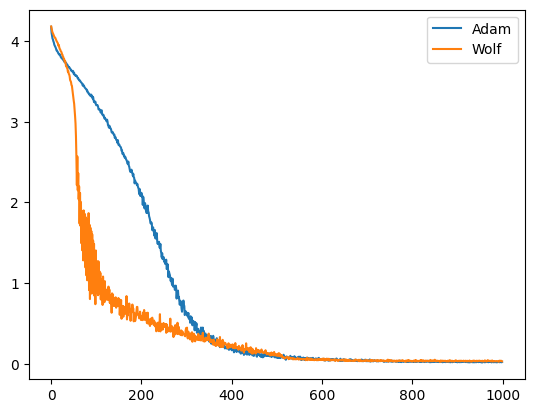
m 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler
import torch.nn.functional as F
import math
import requests

In [2]:
from torch.optim.optimizer import Optimizer
class Wolf(Optimizer):
    """Implements Wolf algorithm."""
    def __init__(self, params, lr=0.25, betas=(0.9, 0.999), eps=1e-8):
        # Define default parameters
        defaults = dict(lr=lr, betas=betas, eps=eps)
        self.lr = lr
        # Initialize the parent Optimizer class first
        super().__init__(params, defaults)
        # Constants specific to Wolf
        # Initialize state for each parameter
        for group in self.param_groups:
            for p in group['params']:
                state = self.state[p]
                state['p'] = torch.zeros_like(p)  # Second moment estimate


    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step and adjusts dropout in transformer blocks."""
        etcerta = 0.367879441  # Constant used in update rule
        et = 1 - etcerta
    
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()
    
        # Iterate over parameter groups.
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                
                grad = p.grad
    
                #  AMP Compatibility: Check for NaN or Inf in gradients
                if torch.isnan(grad).any() or torch.isinf(grad).any():
                    print("Skipping parameter update due to NaN/Inf gradient.")
                    continue  # Skip this update if the gradient has NaN or Inf
    
                state = self.state[p]
                exp_avg = state['p']
    
                # Compute update and update second moment-like state.
                update = exp_avg * et + grad * etcerta
                state['p'] = exp_avg * et + update * etcerta
    
                # Compute sign agreement between update and gradient.
                sign_agreement = torch.sign(update) * torch.sign(grad)
    
                # Where the signs agree (mask is True), update the parameter.
                mask = (sign_agreement > 0)
                adaptive_alpha = group.get('lr', self.lr)
                p.data = torch.where(mask, p.data - adaptive_alpha * update, p.data)
    
                # AMP Compatibility: Ensure a step counter is updated
                state['step'] = state.get('step', 0) + 1  # Track optimization steps
    
        return loss



import torch
import torch.nn.functional as F
import math


def modified_student_t_loss(preds, targets, placeholder_idx, df=2.718, eps=1e-9):
    """Apply modified student_t loss where placeholders are demoted when incorrect."""
    dist_sq = torch.sum((preds - targets) ** 2, dim=-1).clamp(min=eps)
    log_p_unnorm = -0.5 * (df + preds.shape[-1]) * torch.log1p(dist_sq / df)
    log_p = F.log_softmax(log_p_unnorm, dim=-1)
    p = log_p.exp()
    
    # Placeholder demotion
    is_placeholder = (targets == placeholder_idx)
    p = torch.where(is_placeholder, p * (1 - 1/math.e), p)  # Reduce probability of placeholders
    return p
    
def student_t_unembedding(hidden_states, unembedding, df=2.718281828459, eps=1e-9, placeholder_idx=None):
    """
    Student's t-based unembedding with optional placeholder modification.
    
    Arguments:
      hidden_states: (B, S, D)  => model’s output embeddings (hidden state)
      unembedding:   (D, V)    => learnable "word vectors" (unembedding matrix)
      df (float): degrees of freedom for the Student's t distribution
      eps (float): numerical epsilon to avoid log(0) and div-by-zero
      placeholder_idx (int, optional): if provided, indicates the column in the unembedding
          corresponding to the placeholder token. The distances for that token will be adjusted 
          using an adaptive noise factor.
    
    Returns:
      p: (B, S, V)  probability distribution over V vocabulary tokens.
    """
    B, S, D = hidden_states.shape
    V = unembedding.shape[1]

    # Expand hidden => (B, S, 1, D)
    x_expanded = hidden_states.unsqueeze(2)
    # Expand unembedding => (1, 1, V, D)
    w_expanded = unembedding.t().unsqueeze(0).unsqueeze(0)  # shape: (1, 1, V, D)
    
    # Compute squared Euclidean distance between each hidden vector and each unembedding vector.
    dist_sq = torch.sum((x_expanded - w_expanded) ** 2, dim=-1).clamp(min=1e-6)  # (B, S, V)
    
    # If a placeholder index is provided, adjust the distance for that token.
    if placeholder_idx is not None:
        # Create a mask with True at positions corresponding to the placeholder token.
        placeholder_mask = torch.zeros_like(dist_sq, dtype=torch.bool)
        placeholder_mask[..., placeholder_idx] = True

        # Compute the 1/e-th percentile (roughly the 36.8th percentile) over all distances.
        #percentile = 1- (1.0 / math.e) 
        #threshold = torch.quantile(dist_sq.flatten(), percentile)
        t2= torch.quantile(dist_sq.flatten(), (1.0 / math.e))


        # Create a noise factor scaled by the computed threshold.
        noise_factor = torch.randn_like(dist_sq) * 1.0
        noise_factor -= t2

        #allows probability of placeholder to wander, so model is randomly encouraged
        #to try it or avoid it, thus ensuring it will be tried, but, it will also
        #be desired to be avoided. the model will wander from -36% to positive 68%
        #thus, it will be twice as likely to be recommended it as not, 
        #but the median is less than 50%, meaning that,
        #sometimes it is recommended highly, but rarely.
        dist_sq = torch.where(placeholder_mask, dist_sq - noise_factor, dist_sq)
    
    # Compute the negative energy:
    #    E = 0.5*(df + D) * log(1 + dist_sq / df)
    # and so log probability (up to an additive constant) is:
    #    log_p = -E
    log_p_unnorm = -0.5 * (df + D) * torch.log1p(dist_sq / df)  # (B, S, V)
    
    # Normalize via log_softmax over the vocabulary dimension.
    log_p = F.log_softmax(log_p_unnorm, dim=-1)  # (B, S, V)
    p = log_p.exp()
    return p

# ---------------------------------------------------
# Custom Activation
# ---------------------------------------------------
class SelfScalableTanh(nn.Module):
    def __init__(self, init_scale=0.1, max_scale=0.12):
        super().__init__()
        # Learned scale parameter
        self.scale = nn.Parameter(torch.tensor(init_scale, dtype=torch.float32))

    def forward(self, x):
        # "Scaled Tanh"
        scale = torch.clamp(self.scale,0.0,1.0)#prevent NaN collapse
        return torch.tanh(x) + scale * torch.tanh(x)


# ---------------------------------------------------
# Differentiable XOR
# ---------------------------------------------------
class DifferentiableXORLayer(nn.Module):
    """
    Splits the incoming embedding in half, and does a
    sigmoid-based XOR-like transformation.
    """
    def __init__(self, embed_dim):
        super().__init__()
        assert embed_dim % 2 == 0, "embed_dim must be even for XOR."
        self.embed_dim = embed_dim
        self.proj = nn.Linear(embed_dim // 2, embed_dim)

    def forward(self, x):
        d = self.embed_dim // 2
        x1, x2 = x[..., :d], x[..., d:]
        a = torch.sigmoid(x1)
        b = torch.sigmoid(x2)
        # approximate XOR = a + b - 2ab
        xor_out = 0.5 * (a + b - 2 * a * b)  # scaled by 0.5
        out = self.proj(xor_out)
        return out
        
class DifferentiableXORLayer(nn.Module):
    """
    Applies a differentiable XOR transformation to the residual logits.
    """
    def __init__(self, vocab_size):
        super().__init__()
        assert vocab_size % 2 == 0, "Vocab size must be even for XOR."
        self.vocab_size = vocab_size
        self.proj = nn.Linear(vocab_size // 2, vocab_size)  # Ensures mapping stays consistent

    def forward(self, logits):
        """
        logits: (B, S, V) residual logits evolving through layers.

        Returns:
          refined_logits: (B, S, V) with XOR-like transformation.
        """
        d = self.vocab_size // 2
        logits_1, logits_2 = logits[..., :d], logits[..., d:]

        a = torch.sigmoid(logits_1)
        b = torch.sigmoid(logits_2)

        # Approximate XOR for probability space
        xor_logits = 0.5 * (a + b - 2 * a * b)  # Differentiable XOR
        refined_logits = self.proj(xor_logits)  # Learnable projection

        return refined_logits


class TapeHeadBlock(nn.Module):
    def __init__(self, chunk_size, embed_dim,vocab_size, num_heads=1, placeholder_idx=None, dropout=0.1):
        super().__init__()
        self.chunk_size = chunk_size
        self.embed_dim = embed_dim

        # Chunk-based attention
        self.chunk_proj = nn.Linear(chunk_size * embed_dim, embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)
        self.ln_attn = nn.LayerNorm(embed_dim)

        # MLP
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, 4 * embed_dim),
            SelfScalableTanh(),
            nn.Linear(4 * embed_dim, embed_dim),
            nn.Dropout(dropout),
        )
        self.ln_mlp = nn.LayerNorm(embed_dim)

        # Unembedding for this block
        self.unembedding = nn.Parameter(torch.randn(embed_dim, vocab_size))
        nn.init.kaiming_uniform_(self.unembedding, a=math.sqrt(5))

        # **Logits Attention Layer**: Learns to selectively use past logits
        self.logits_attention = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.placeholder_idx = placeholder_idx
    def forward(self, x, h, logits):
        """
        x:      (B, S, D) original input
        h:      (B, S, D) current hidden state
        logits: (B, S, V) probability distribution from previous block

        Returns:
          x: same input
          h: updated hidden state
          logits: refined probability distribution
        """
        # 1) Chunk-based attention
        attn_out = self._chunk_attention(h)  # (B, S, D)
        h_attn = self.ln_attn(h + attn_out)  # residual + LN

        # 2) Convert logits into an embedding (if logits exist)
        if logits is not None:
            vocab_embedding = torch.matmul(logits, self.unembedding.T)  # (B, S, D)

            # **Learnable Cross-Attention Over Logits**
            query = h_attn
            key = vocab_embedding
            value = vocab_embedding
            logits_context, _ = self.logits_attention(query, key, value)

            # Merge the logits-based signal into h
            h_attn = h_attn + logits_context  # Now it's conditioned on past logits

        # 3) MLP processing
        h_mlp = self.ln_mlp(h_attn + self.mlp(h_attn))

        # 4) Compute new logits
        logits = student_t_unembedding(h_mlp, self.unembedding,placeholder_idx=self.placeholder_idx)

        return x, h_mlp, logits  # Pass refined logits forward


    def _chunk_attention(self, h):
        """ Chunk-based self-attention """
        B, S, D = h.shape
        c = self.chunk_size

        # Move feature dim before sequence (B, D, S)
        x_3d = h.permute(0, 2, 1)

        # Right-pad so we can slide windows of size c up to the last token
        x_3d_padded = F.pad(x_3d, (0, c - 1))

        # Unfold => (B, D*c, S)
        unfolded = F.unfold(x_3d_padded.unsqueeze(-1), kernel_size=(c, 1), stride=(1, 1))
        unfolded = unfolded.transpose(1, 2)  # => (B, S, D*c)

        # Project => (B, S, D)
        chunk_tensor = self.chunk_proj(unfolded)

        # Self-attention
        out, _ = self.attn(chunk_tensor, chunk_tensor, chunk_tensor)
        return out

class TapeHead(nn.Module):
    """
    A Transformer-like block with progressive chunk sizes.
    Each layer inside the TapeHead doubles the chunk size.
    """
    def __init__(self, embed_dim, vocab_size, num_layers=3, base_chunk=1, num_heads=2, placeholder_idx=None,dropout=0.1):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_layers = num_layers
        self.base_chunk = base_chunk

        # Create progressively larger TapeHeadBlocks
        self.blocks = nn.ModuleList([
            TapeHeadBlock(
                chunk_size=base_chunk * (2 ** i),  # 1, 2, 4, 8, ...
                embed_dim=embed_dim,vocab_size=vocab_size,
                num_heads=num_heads,placeholder_idx=placeholder_idx,
                dropout=dropout
            )
            for i in range(num_layers)
        ])

    def forward(self, x, h,logits):
        """
        x: (B, S, D) original input
        h: (B, S, D) hidden state

        Returns:
          x: original input (unchanged)
          h: final refined hidden state
        """
        for block in self.blocks:
            x, h, logits = block(x, h, logits)  # Process each block progressively
        return x, h ,logits 

class RMSNorm(nn.Module):
    def __init__(self, dim, eps=1e-8):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(dim))
        self.eps = eps

    def forward(self, x):
        return x / (x.norm(2, dim=-1, keepdim=True) + self.eps) * self.weight
        
class TapeTransformer(nn.Module):
    """
    Full GPT-like model with:
      - Token + Position Embeddings
      - Multiple stacked TapeHeads
      - XOR applied to each TapeHead output
      - Final Student-t unembedding
    """
    def __init__(self, vocab_size, seq_len=128,chunk_len=4, embed_dim=128, num_heads=2, num_layers=4, placeholder_idx=None, dropout=0.1):
        super().__init__()
        self.vocab_size = vocab_size
        self.seq_len = seq_len
        self.embed_dim = embed_dim

        # Token & Positional Embeddings
        self.token_emb = nn.Embedding(vocab_size, embed_dim)
        self.pos_emb = nn.Parameter(torch.zeros(1, seq_len, embed_dim))
        num_chunk_layers = math.ceil(math.log2(chunk_len))  # Computes the exponent of the next power of 2

        # Stacked TapeHeads and corresponding XOR modules
        self.tape_heads = nn.ModuleList([
            TapeHead(embed_dim, vocab_size=vocab_size, num_layers=num_chunk_layers, base_chunk=1, num_heads=num_heads,placeholder_idx=placeholder_idx, dropout=dropout)
            for _ in range(num_layers)
        ])
        self.xor_modules = nn.ModuleList([
            DifferentiableXORLayer(vocab_size) for _ in range(num_layers)
        ])
        self.final_norm = RMSNorm(embed_dim)
        self.logits_norm = nn.LayerNorm(embed_dim)

        self.norm_gate = nn.Parameter(torch.tensor(0.5))  # Start at 0.5 for balanced effect

        # Final Student-t unembedding
        self.final_ln = nn.LayerNorm(embed_dim)
        self.logits_weight = nn.Parameter(torch.tensor(0.5))  # Initialized to 0.5, learnable scalar
        self.unembedding = nn.Parameter(torch.randn(embed_dim, vocab_size))
        nn.init.kaiming_uniform_(self.unembedding, a=math.sqrt(5))

    def forward(self, x):
        """
        x: (B, S) integer token IDs
        Returns:
          p_final: (B, S, V) final probability distribution
        """
        x = x.unsqueeze(0) if x.ndim == 1 else x  # Ensure batch dimension

        B, S = x.shape
        assert S <= self.seq_len, "Sequence too long."

        # 1) Token + Positional Embeddings
        h = self.token_emb(x) + self.pos_emb[:, :S, :]  # (B, S, D)
        logits = None
        
        # 2) Pass through TapeHeads and apply XOR after each
        for head, xor in zip(self.tape_heads, self.xor_modules):
            x, h, logits = head(x, h,logits)
            if logits is not None and logits.numel() > 0:  # Ensure logits exist before applying XOR
                logits = xor(logits)              # Apply XOR
            
        ## 3) Process logits before merging
        #if logits is not None:
            #logits_emb = torch.matmul(logits, self.unembedding.T)  # (B, S, D)
            #logits_emb = self.logits_norm(logits_emb)  # **Normalize logits before merging**

        # 4) Final processing
        #alpha = torch.sigmoid(self.norm_gate)  # Learnable balance factor
        h_final = self.final_norm(h) #+ alpha * logits_emb # Blended normalization
        p_final = student_t_unembedding(h, self.unembedding, df=2.718281828459, eps=1e-9,placeholder_idx=placeholder_idx)


        return p_final




In [3]:
import gc,torch

gc.collect()
torch.cuda.empty_cache()

In [ ]:
# ====================================================
# Data Preparation (Shakespeare)
# ====================================================
def load_shakespeare_text():
    url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
    text = requests.get(url).text
    return text

text = load_shakespeare_text()
chars = sorted(list(set(text)))

# Add a placeholder token: an ASCII grey block (visible in output)
placeholder = "▒"  # Choose your preferred grey block character
if placeholder not in chars:
    chars.append(placeholder)
    chars.sort()  # Ensure ordering is maintained

vocab_size = len(chars)
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for i, ch in enumerate(chars)}
placeholder_idx = stoi[placeholder]
print("Placeholder token:", placeholder, "with index:", placeholder_idx)


def encode(s):
    return [stoi[c] for c in s]

def decode(l):
    return ''.join([itos[i] for i in l])

data = torch.tensor(encode(text), dtype=torch.long)

def get_batch(batch_size, seq_len):
    ix = torch.randint(0, data.size(0) - seq_len - 1, (batch_size,))
    x = torch.stack([data[i:i+seq_len] for i in ix])
    y = torch.stack([data[i+1:i+seq_len+1] for i in ix])
    return x, y
    
import numpy as np
import itertools

# Get unique characters and their frequencies
chars = sorted(list(set(text)))
char_counts = {ch: text.count(ch) for ch in chars}
total_chars = sum(char_counts.values())

# Compute empirical probabilities
char_probs = {ch: count / total_chars for ch, count in char_counts.items()}

# Convert to sorted lists for indexing
char_list = sorted(char_probs.keys())
prob_list = np.array([char_probs[ch] for ch in char_list])

# Compute a distance matrix based on probability space
distance_matrix = np.zeros((len(char_list), len(char_list)))

for i, j in itertools.combinations(range(len(char_list)), 2):
    # Construct two-outcome distributions for each character probability
    p, q = prob_list[i], prob_list[j]
    # For our purposes, consider distributions like [p, 1-p] and [q, 1-q]
    m = 0.5 * (p + q)
    distance = 0.5 * (p * np.log(p/m) + (1-p) * np.log((1-p)/(1-m)) +
                      q * np.log(q/m) + (1-q) * np.log((1-q)/(1-m)))
    distance_matrix[i, j] = char_distance_matrix[j, i] = distance



# ====================================================
# Training Setup
# ====================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TapeTransformer(
    vocab_size=vocab_size,  # example
    seq_len=256,
    chunk_len=4,
    embed_dim=256,
    num_layers=6,
    num_heads=4,
    placeholder_idx=placeholder_idx,
    dropout=0 #cannot use dropout, tooo slow
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=6e-4)

scaler = GradScaler()

num_epochs = 100
batch_size = 16
seq_len = 256 #from karapathy


losses = []


In [ ]:
plt.imshow(distance_matrix)

In [ ]:
len(text)

In [ ]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
def modified_loss(preds, targets, placeholder_idx, df=2.718281828459, eps=1e-9):
    """
    Custom loss function to implement 'Skip vs Learn' behavior.

    Arguments:
      preds: (B, S, V) => Model's predicted probabilities over vocabulary.
      targets: (B, S) => Ground truth token indices.
      placeholder_idx: Index of the placeholder token.
      df (float): Degrees of freedom for Student's t-distribution.
      eps (float): Small constant to prevent log(0).

    Returns:
      Scalar loss.
    """
    B, S, V = preds.shape

    # Get predicted token indices
    pred_indices = torch.argmax(preds, dim=-1)

    # Identify where ground truth is a placeholder
    is_placeholder = (targets == placeholder_idx)
    is_pred_placeholder = (pred_indices == placeholder_idx)

    # Compute standard loss
    log_probs = torch.log(preds + eps)
    loss = -log_probs[torch.arange(B).unsqueeze(1), torch.arange(S).unsqueeze(0), targets]

    # Case 1: Model predicts a real token when ground truth is a placeholder → Reward
    loss = torch.where(is_placeholder & ~is_pred_placeholder, loss * (1 - 1 / math.e), loss)

    # Case 2: Model predicts placeholder when ground truth is a real token → Penalize
    loss = torch.where(~is_placeholder & is_pred_placeholder, loss * (1 + 1 / math.e), loss)

    return loss.mean()


def corrupt_input_probability_based(batch, char_list, char_probs, distance_matrix, corruption_prob=1 / math.e):
    """
    Corrupts a batch of tokenized text based on probability-space distances.
    
    Arguments:
      batch: (B, S) Tensor of token indices.
      char_list: List of characters sorted by index.
      char_probs: Dictionary mapping character to probability.
      distance_matrix: Precomputed Jensen-Shannon distances between character probabilities.
      corruption_prob: Probability of corrupting a token.
    
    Returns:
      Corrupted batch tensor.
    """
    batch_size, seq_len = batch.shape
    corrupted_batch = batch.clone()
    
    for i in range(batch_size):
        for j in range(seq_len):
            if random.random() < corruption_prob:
                original_idx = batch[i, j].item()
                original_char = char_list[original_idx]
                
                # Get distances from the current character to all others
                distances = distance_matrix[original_idx]
                
                # Select replacement character based on a random weighted shift
                shift_distance = np.percentile(distances, 1 / math.e * 100)  # Determine shift threshold
                valid_replacements = np.where(distances >= shift_distance)[0]  # Find candidates beyond threshold
                
                if len(valid_replacements) > 0:
                    replacement_idx = np.random.choice(valid_replacements)  # Pick a random valid distant character
                    corrupted_batch[i, j] = replacement_idx
    
    return corrupted_batch


def scheduled_sampling(batch, model, placeholder_idx, sample_prob, gen_chars,char_list, char_probs, distance_matrix):
    """
    Implements scheduled sampling with corruption and variable-length generation.
    Ensures truncation never results in fewer than 3 characters.

    Arguments:
      batch: (B, S) Tensor of token indices.
      model: Transformer model.
      placeholder_idx: Index of the placeholder token.
      max_truncate: Upper bound for truncation.
      sample_prob: Probability of using model-generated token instead of ground truth.
      gen_chars: Number of characters to generate instead of ground truth.

    Returns:
      Loss scalar.
    """
    batch_size, seq_len = batch.shape
    truncated_batch = []
    targets = []
    use_placeholder = torch.rand(1).item() < (1 / math.e)  # 1/e probability for forced placeholders

    for i in range(batch_size):
        # Ensure truncation is never less than 3 chars
        min_truncate = 3
        max_truncate = model.seq_len
        max_valid_truncate = min(max_truncate, model.seq_len - gen_chars - 1)

        # Ensure we have a valid range
        if max_valid_truncate < min_truncate:
            truncate_len = min_truncate  # If max is too small, just use min
        else:
            truncate_len = random.randint(min_truncate, max_valid_truncate)

        # Select truncated sequence
        input_seq = batch[i, :truncate_len].clone()
        target_seq = batch[i, truncate_len : min(truncate_len + gen_chars, seq_len)]  # Multiple target characters

        # Scheduled sampling: replace last `gen_chars` tokens with model predictions
        if random.random() < sample_prob and truncate_len > 1:
            with torch.no_grad():
                for _ in range(gen_chars):
                    if len(input_seq) >= model.seq_len:  # Prevent overflow
                        break
                    model_output = model(input_seq.unsqueeze(0))  # (1, S, V)
                    predicted_token = torch.argmax(model_output[:, -1, :], dim=-1)
                    input_seq = torch.cat([input_seq, predicted_token.view(1)], dim=0)  # Append predicted token

        # corruption
        input_seq = corrupt_input_probability_based(
            input_seq.unsqueeze(0), char_list, char_probs, distance_matrix, corruption_prob=1 / math.e
        ).squeeze(0)

        truncated_batch.append(input_seq[:model.seq_len])  # Ensure length limit
        targets.append(target_seq[:model.seq_len])  # Ensure target sequence is also within bounds

    # **Pad sequences to the max length in batch**
    max_len = max(len(seq) for seq in truncated_batch)
    max_len = min(max_len, model.seq_len)  # Ensure padding does not exceed max sequence length

    truncated_batch = [F.pad(seq, (0, max_len - len(seq)), value=placeholder_idx) for seq in truncated_batch]
    targets = [F.pad(seq, (0, max_len - len(seq)), value=placeholder_idx) for seq in targets]

    truncated_batch = torch.stack(truncated_batch)
    targets = torch.stack(targets)

    # Forward pass
    outputs = model(truncated_batch)

    # Compute custom loss (ignoring padded regions)
    loss = modified_loss(outputs, targets, placeholder_idx)

    return loss.mean()


for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    # Increase sample probability over time
    sample_prob = min(0.1 * (epoch + 1), 0.5)  # Linearly increases up to 50%
    gen_chars = min(1 + epoch, 5)  # Gradually increase generated tokens per epoch

    for step in range(100):  # Adjust as needed
        x_batch, _ = get_batch(batch_size, seq_len)
        x_batch = x_batch.to(device)
        
        optimizer.zero_grad()
        with autocast():

            loss = scheduled_sampling(x_batch, model, placeholder_idx, sample_prob, gen_chars,char_list, char_probs, distance_matrix)
        main_loss = loss.detach()
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()

        total_loss += main_loss
        losses.append(main_loss.cpu())
        if step % 1 == 0:
            print(f"Epoch {epoch+1}, Step {step}, Loss: {main_loss:.4f}")

    print(f"Epoch {epoch+1} Average Loss: {total_loss/1000:.4f}")

In [ ]:
# ====================================================
# Evaluation: Text Generation
# ====================================================

model.eval()
with torch.no_grad():
    prompt = "oh Romeo! Romeo!"
    context = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)
    generated = context
    for _ in range(200):  # Generate 200 tokens.
        inp = generated[:, -seq_len:]
        p = model(inp)  # p: (B, seq, vocab_size)
        last_token_probs = p[:, -1, :]  # Shape: [batch_size, vocab_size]
        predicted_token = torch.multinomial(F.softmax(last_token_probs, dim=-1), num_samples=1).squeeze()

        #next_token = torch.multinomial(last_token_probs, num_samples=1)
        generated = torch.cat((generated, next_token), dim=1)
    sample = decode(generated[0].cpu().tolist())
    print("Generated Sample:\n", sample)


In [ ]:
from matplotlib import pyplot as plt
plt.plot(losses)
plt.show()